In [1]:
%matplotlib inline

""" Forces colab to use the correct version of opencv, sets up matlab, imports
!pip install opencv-contrib-python==4.3.0.38
"""
!pip install opencv-contrib-python==4.3.0.38

import matplotlib
import matplotlib.pyplot as plt
import cv2
import numpy as np
from numpy.linalg import svd as svd
from numpy.linalg import norm as norm
from numpy.linalg import inv as inv
from numpy.linalg import det as det
from numpy.linalg import pinv as pinv
from datetime import datetime


image shape: (426, 568, 3)


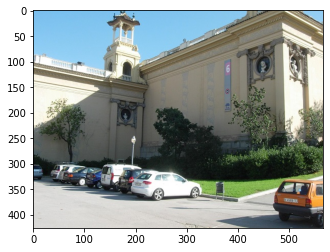

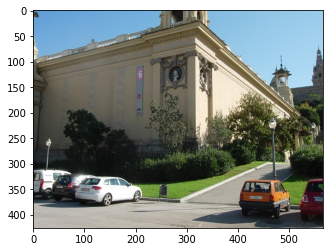

In [2]:
"""  This loads the images.  You must first upload the images to your colab
session.  Each time you start a new session, you will need to upload them again.
"""
im_left = cv2.imread('demo_1.jpg')
print("image shape:", im_left.shape)
plt.imshow(im_left[:, :, ::-1])
plt.figure()
im_right = cv2.imread('demo_2.jpg')
plt.imshow(im_right[:, :, ::-1])
images = [im_left, im_right]

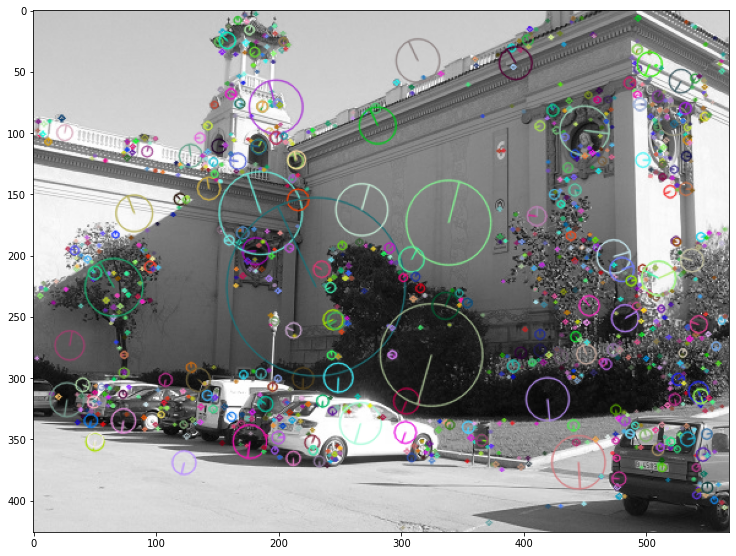

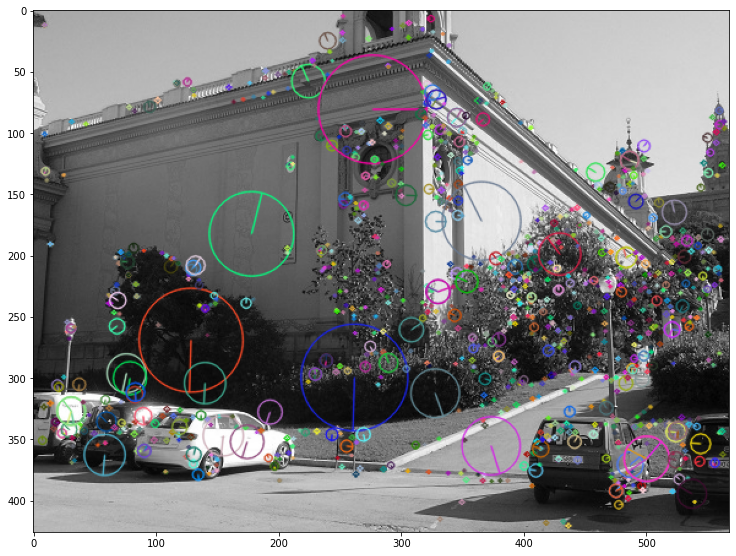

In [3]:
""" Detects SIFT features in all of the images
"""
keypoints = []
descriptions = []
for im in images:
  gray= cv2.cvtColor(im,cv2.COLOR_RGB2GRAY)

  sift = cv2.xfeatures2d.SIFT_create()
  kp, des = sift.detectAndCompute(gray,None)

  keypoints.append(kp)
  descriptions.append(des)

  plt.figure(figsize=(6.4*2, 4.8*2))
  out_im = cv2.drawKeypoints(gray,kp, gray, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

  plt.imshow(out_im)

num matches 456


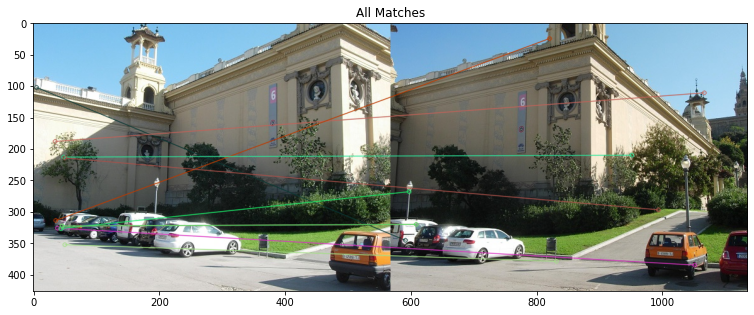

In [4]:
""" Matches the detected keypoints between the images
"""

bf = cv2.BFMatcher(crossCheck=True)
matches = bf.match(descriptions[0], descriptions[1])

print("num matches", len(matches))

matched_image = cv2.drawMatches(images[0][:, :, ::-1], keypoints[0], images[1][:, :, ::-1], keypoints[1], matches[:10], None, flags=2)
plt.figure(figsize=(6.4*2, 4.8*2))
plt.title("All Matches")
plt.imshow(matched_image)
plt.show()

In [5]:
""" Compute calibrated coordinates
"""
f=596.4 
u0 = 284
v0 = 213

K = np.array([[f, 0, u0],
              [0, f, v0],
              [0, 0, 1]])


uncalibrated_1 = [[keypoints[0][match.queryIdx].pt[0], keypoints[0][match.queryIdx].pt[1], 1] for match in matches]
uncalibrated_2 = [[keypoints[1][match.trainIdx].pt[0], keypoints[1][match.trainIdx].pt[1], 1] for match in matches]

uncalibrated_1 = np.array(uncalibrated_1).T
uncalibrated_2 = np.array(uncalibrated_2).T

k_inv = np.linalg.inv(K)

calibrated_1 = np.matmul(k_inv, uncalibrated_1).T
calibrated_2 = np.matmul(k_inv, uncalibrated_2).T

In [6]:
def least_squares_estimation(X1, X2):
  A = X1[:, 0] * X2.T
  B = X1[:, 1] * X2.T
  C = X1[:, 2] * X2.T

  mat = np.hstack((A.T, B.T, C.T))
  U, S, V = svd(mat)
  
  E = (V.T)[:, -1].reshape(3, 3)
  
  U, S, V = svd(E)
  d = np.diag([1, 1, 0])
  E = (U @ d @ V).T
  
  return E

E_least = least_squares_estimation(calibrated_1, calibrated_2)
print("E least")
print(np.around(E_least, 2))

E least
[[ 0.73 -0.67  0.14]
 [ 0.67  0.74 -0.01]
 [-0.12  0.01 -0.01]]


In [7]:
def ransac_estimator(X1, X2):
  num_iterations = 20000 
  sample_size = 8

  eps = 10**-4

  best_num_inliers = -1
  best_inliers = None
  best_E = None

  for iter in range(num_iterations):
    permuted_indices = np.random.permutation(np.arange(X1.shape[0] - 1))
    sample_indices = permuted_indices[:sample_size]
    test_indices = permuted_indices[sample_size:]

    inlier_arr = []

    # Step 1: Sample and Test Coordinates
    x1_sample = X1[sample_indices]
    x2_sample = X2[sample_indices]

    x1_test = X1[test_indices].T
    x2_test = X2[test_indices].T

    # Step 2: Generate E matrix
    E = least_squares_estimation(x1_sample, x2_sample)

    # Step 3: Determine if test coordinates are inliers
    residual_arr = []

    test_ix_arr = list(range(len(test_indices)))
    #print(test_ix_arr)

    E_X1 = E @ x1_test[:, test_ix_arr]
    print(x2_test.shape, x1_test.shape, E.shape, x2_test[:, test_ix_arr].T.shape)
    residual_num = (x2_test[:, test_ix_arr].T @ E).T @ x1_test[:, test_ix_arr].T
    residual_den = norm(E_X1[:2])
    residual_arr.append(residual_num**2 / residual_den)

    E_X2 = E.T @ x2_test[:, test_ix_arr]
    residual_num = (x1_test[:, test_ix_arr].T @ E.T) @ x2_test[:, test_ix_arr] 
    residual_den = norm(E_X2[:2])
    residual_arr.append(residual_num**2 / residual_den)
    
    print(residual_arr)
    #inlier_arr.append(np.where(sum(residual_arr) < eps))
    #inliers = np.array(inlier_arr).T

    if inliers.shape[0] > best_num_inliers:
      best_num_inliers = inliers.shape[0]
      best_E = E
      best_inliers = inliers

    if (iter + 1) % 1000 == 0: 
      now = datetime.now()
      current_time = now.strftime("%H:%M:%S")
      print(str(iter+1) + " / " + str(num_iterations) + "   " + str(current_time))      


  return best_E, best_inliers

%time E_ransac, inliers = ransac_estimator(calibrated_1, calibrated_2)
print("E_ransac")
print(np.around(E_ransac, 2))
print("Num inliers", inliers.shape)

inlier_matches = [matches[i] for i in inliers]

matched_image = cv2.drawMatches(images[0][:, :, ::-1],
                                keypoints[0],
                                images[1][:, :, ::-1],
                                keypoints[1],
                                inlier_matches, None, flags=2)
plt.figure(figsize=(6.4*2, 4.8*2))
plt.title("RANSAC Inlier Matches")
plt.imshow(matched_image)
plt.show()

(3, 447) (3, 447) (3, 3) (447, 3)
[array([[3.52097058e+00, 3.36495472e-01, 7.32059558e+01],
       [1.57622707e+02, 1.26544558e-02, 1.06755428e+04],
       [1.45546057e+01, 3.15793921e-01, 6.22222533e+02]]), array([[1.02206171e-04, 1.24238571e-04, 7.07811136e-04, ...,
        2.63197714e-03, 3.25591448e-03, 2.92199483e-03],
       [7.46834611e-04, 8.26109724e-04, 6.34751258e-05, ...,
        1.03261646e-03, 5.07414507e-03, 1.21554338e-03],
       [1.04057420e-03, 1.16325838e-03, 3.12784339e-04, ...,
        2.67583557e-03, 8.99318273e-03, 3.08705871e-03],
       ...,
       [1.38565695e-03, 1.36107528e-03, 8.67756544e-03, ...,
        1.67731070e-02, 1.44238060e-03, 1.78097802e-02],
       [1.15644048e-02, 1.19092506e-02, 2.29955083e-02, ...,
        3.18381222e-02, 1.82895229e-03, 3.28219292e-02],
       [1.63526557e-04, 1.90531635e-04, 4.01466222e-04, ...,
        1.78151930e-03, 2.97044753e-03, 1.99692398e-03]])]


NameError: ignored

In [ ]:
def plot_lines(lines, h, w):
  """ Utility function to plot lines
  """

  for i in range(lines.shape[1]):
    if abs(lines[0, i] / lines[1, i]) < 1:
      y0 = -lines[2, i] / lines[1, i]
      yw = y0 - w * lines[0, i] / lines[1, i]
      plt.plot([0, w], [y0, yw])
    else:
      x0 = -lines[2, i] / lines[0, i]
      xh = x0 - h * lines[1, i] / lines[0, i]
      plt.plot([x0, xh], [0, h])

In [ ]:
def plot_epipolar_lines(image1, image2, uncalibrated_1, uncalibrated_2, E, K):
  """ Plots the epipolar lines on the images
  """

  fundamental_mat = inv(K).T @ E @ inv(K)
  epipolar_lines_in_1 = fundamental_mat.T @ uncalibrated_2
  epipolar_lines_in_2 = fundamental_mat @ uncalibrated_1

  plt.figure(figsize=(6.4*3, 4.8*3))
  ax = plt.subplot(1, 2, 1)
  ax.set_xlim([0, image1.shape[1]])
  ax.set_ylim([image1.shape[0], 0])
  plt.imshow(image1[:, :, ::-1])
  plot_lines(epipolar_lines_in_1, image1.shape[0], image1.shape[1])

  ax = plt.subplot(1, 2, 2)
  ax.set_xlim([0, image1.shape[1]])
  ax.set_ylim([image1.shape[0], 0])
  plt.imshow(image2[:, :, ::-1])
  plot_lines(epipolar_lines_in_2, image2.shape[0], image2.shape[1])
  plt.show()


uncalibrated_inliers_1 = [[keypoints[0][match.queryIdx].pt[0], keypoints[0][match.queryIdx].pt[1], 1] for match in inlier_matches]
uncalibrated_inliers_2 = [[keypoints[1][match.trainIdx].pt[0], keypoints[1][match.trainIdx].pt[1], 1] for match in inlier_matches]
uncalibrated_inliers_1 = np.array(uncalibrated_inliers_1).T
uncalibrated_inliers_2 = np.array(uncalibrated_inliers_2).T

plot_epipolar_lines(images[0], images[1], uncalibrated_inliers_1, uncalibrated_inliers_2, E_ransac, K)

In [ ]:
def pose_canidates_from_E(E):
  transform_canidates = []

  rot_array = []
  trans_array = []
  
  # Step 1: First Pose Candidate
  U, S, V = svd(E)
  positive_Rz = np.diag([0, 0, 1])
  positive_Rz[0, 1] = -1
  positive_Rz[1, 0] = 1
  
  rotation = U @ positive_Rz.T @ V
  if det(rotation) < 0:
    positive_Rz[2, 2] = det(U @ V)
    rotation = U @ positive_Rz.T @ V

  rot_array.append(rotation)

  translation = U[:, 2]
  trans_array.append(translation)

  # Step 2: Second Pose Candidate
  negative_Rz = np.diag([0, 0, 1])
  negative_Rz[0, 1] = 1
  negative_Rz[1, 0] = -1
  
  rotation = U @ negative_Rz.T @ V
  if det(rotation) < 0:
    negative_Rz[2, 2] = det(U @ V)
    rotation = U @ negative_Rz.T @ V

  rot_array.append(rotation)

  translation = -U[:, 2]
  trans_array.append(translation)

  # Step 3: Third Pose Candidate
  U, S, V = svd(-E)
  positive_Rz = np.diag([0, 0, 1])
  positive_Rz[0, 1] = -1
  positive_Rz[1, 0] = 1
  
  rotation = U @ positive_Rz.T @ V
  if det(rotation) < 0:
    positive_Rz[2, 2] = det(U @ V)
    rotation = U @ positive_Rz.T @ V

  rot_array.append(rotation)

  translation = U[:, 2]
  trans_array.append(translation)

  # Step 4: Fourth Pose Candidate
  negative_Rz = np.diag([0, 0, 1])
  negative_Rz[0, 1] = 1
  negative_Rz[1, 0] = -1
  
  rotation = U @ negative_Rz.T @ V
  if det(rotation) < 0:
    negative_Rz[2, 2] = det(U @ V)
    rotation = U @ negative_Rz.T @ V

  rot_array.append(rotation)

  translation = -U[:, 2]
  trans_array.append(translation)

  ## Create dictionary of pose candidates
  for i in range(4):
    candidate = {}
    candidate['R'] = rot_array[i]
    candidate['T'] = trans_array[i]
    transform_canidates.append(candidate)

  return transform_canidates

transform_canidates = pose_canidates_from_E(E_ransac)
print("transform_canidates")
print(transform_canidates)

In [ ]:
def plot_reconstruction(P1, P2, T, R):
  P1trans = (R @ P1.T).T + T

  plt.figure(figsize=(6.4*2, 4.8*2))
  ax = plt.axes()
  ax.set_xlabel('x')
  ax.set_ylabel('z')
  plt.plot([0], [0], 'bs')
  plt.plot([T[0]], [T[2]], 'ro')

  for i in range(P1.shape[0]):
    plt.plot([0, P2[i, 0]], [0, P2[i, 2]], 'bs-')
    plt.plot([T[0], P1trans[i, 0]], [T[2], P1trans[i, 2]], 'ro-')

In [ ]:
def reconstruct3D(transform_canidates, calibrated_1, calibrated_2):
  """This functions selects (T,R) among the 4 candidates transform_candidates
  such that all triangulated points are in front of both cameras.
  """

  best_num_front = -1
  best_canidate = None
  best_lambdas = None
  for canidate in transform_canidates:
    R = canidate['R']
    T = canidate['T']

    lambdas = np.zeros((2, calibrated_1.shape[0]))

    for i in range(calibrated_1.shape[0]):
      calibrated_rot = -R @ calibrated_1[i]
      lambda_i = pinv(np.vstack((calibrated_2[i], calibrated_rot)).T) @ T
      lambdas[:, i] = lambda_i

    num_front = np.sum(np.logical_and(lambdas[0]>0, lambdas[1]>0))

    if num_front > best_num_front:
      best_num_front = num_front
      best_canidate = canidate
      best_lambdas = lambdas
      print("best", num_front, best_lambdas[0].shape)
    else:
      print("not best", num_front)


  P1 = best_lambdas[1].reshape(-1, 1) * calibrated_1
  P2 = best_lambdas[0].reshape(-1, 1) * calibrated_2
  T = best_canidate['T']
  R = best_canidate['R']
  return P1, P2, T, R


P1, P2, T, R = reconstruct3D(transform_canidates, calibrated_1, calibrated_2)


plot_reconstruction(P1, P2, T, R)

In [ ]:
def show_reprojections(image1, image2, uncalibrated_1, uncalibrated_2, P1, P2, K, T, R):

  P1proj = np.zeros((3, P1.shape[0]))
  P2proj = np.zeros(P1proj.shape)
  
  for i in range(P1.shape[0]):
    P1proj[:, i] = K @ ((R @ P1[i].T) + T )
    P2proj[:, i] = K @ ((R @ P2[i].T) + T )
  
  P1proj = P1proj.T
  P2proj = P2proj.T

  plt.figure(figsize=(6.4*3, 4.8*3))
  ax = plt.subplot(1, 2, 1)
  ax.set_xlim([0, image1.shape[1]])
  ax.set_ylim([image1.shape[0], 0])
  plt.imshow(image1[:, :, ::-1])
  plt.plot(P2proj[:, 0] / P2proj[:, 2],
           P2proj[:, 1] / P2proj[:, 2], 'bs')
  plt.plot(uncalibrated_1[0, :], uncalibrated_1[1, :], 'ro')

  ax = plt.subplot(1, 2, 2)
  ax.set_xlim([0, image1.shape[1]])
  ax.set_ylim([image1.shape[0], 0])
  plt.imshow(image2[:, :, ::-1])
  plt.plot(P1proj[:, 0] / P1proj[:, 2],
           P1proj[:, 1] / P1proj[:, 2], 'bs')
  plt.plot(uncalibrated_2[0, :], uncalibrated_2[1, :], 'ro')

show_reprojections(images[0], images[1], uncalibrated_1, uncalibrated_2, P1, P2, K, T, R)